# LSTM Model for Engine Fault Classification

This notebook trains an LSTM model for sequential time series classification.

## 1. Setup and Data Loading

In [1]:
# Imports
import time
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds
torch.manual_seed(42)

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# Load datasets
data_dir = Path("../results/datasets")

train_data = torch.load(data_dir / "train_sequential.pt", weights_only=False)
val_data = torch.load(data_dir / "val_sequential.pt", weights_only=False)
test_data = torch.load(data_dir / "test_sequential.pt", weights_only=False)

# Convert to TensorDataset
train_X = torch.stack([x for x, y in train_data['samples']])
train_y = torch.stack([y for x, y in train_data['samples']])
train_dataset = TensorDataset(train_X, train_y)

val_X = torch.stack([x for x, y in val_data['samples']])
val_y = torch.stack([y for x, y in val_data['samples']])
val_dataset = TensorDataset(val_X, val_y)

test_X = torch.stack([x for x, y in test_data['samples']])
test_y = torch.stack([y for x, y in test_data['samples']])
test_dataset = TensorDataset(test_X, test_y)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"\nInput shape: {train_X[0].shape}  # [window_size, num_sensors]")

Train samples: 171443
Val samples: 37658
Test samples: 37658

Input shape: torch.Size([10, 20])  # [window_size, num_sensors]


In [9]:
# Configuration
BATCH_SIZE = 32
SEQ_LENGTH = train_X.shape[1]  # 10 timesteps
INPUT_SIZE = train_X.shape[2]  # 20 sensors
HIDDEN_SIZE = 64
NUM_LAYERS = 2
NUM_CLASSES = 5
NUM_EPOCHS = 50
LEARNING_RATE = 0.005

print(f"Configuration:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Sequence length: {SEQ_LENGTH}")
print(f"  Input size: {INPUT_SIZE}")
print(f"  Hidden size: {HIDDEN_SIZE}")
print(f"  Num layers: {NUM_LAYERS}")
print(f"  Num classes: {NUM_CLASSES}")

Configuration:
  Batch size: 32
  Sequence length: 10
  Input size: 20
  Hidden size: 64
  Num layers: 2
  Num classes: 5


In [10]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

DataLoaders created:
  Train batches: 5358
  Val batches: 1177
  Test batches: 1177


## 2. Model Definition

In [11]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Classification head
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # x shape: [batch, seq_len, input_size]
        
        # LSTM
        lstm_out, (h_n, c_n) = self.lstm(x)
        # h_n shape: [num_layers, batch, hidden_size]
        
        # Use the last hidden state from the last layer
        h_last = h_n[-1]  # [batch, hidden_size]
        
        # Classification
        out = self.dropout(h_last)
        logits = self.fc(out)
        
        return logits

print("Model class defined.")

Model class defined.


## 3. Training and Evaluation Functions

In [12]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for X_batch, y_batch in pbar:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.cpu().numpy())
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1


def evaluate(model, loader, criterion, device):
    """Evaluate the model."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in tqdm(loader, desc='Evaluating', leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            
            total_loss += loss.item()
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1, all_preds, all_labels

print("Training and evaluation functions defined.")

Training and evaluation functions defined.


## 4. Training

In [13]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMClassifier(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

print(f"Device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Device: cuda
Model parameters: 55,621


In [14]:
# Training loop
best_val_f1 = 0
patience = 5
patience_counter = 0

history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

start_time = time.time()

print("Starting training...")
print("=" * 70)

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    # Train
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, criterion, device)
    
    epoch_time = time.time() - epoch_start
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    # Print progress
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")
    print(f"  Epoch time: {epoch_time:.1f}s")
    
    # Early stopping
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), "../results/best_lstm_model.pt")
        print(f"  ✓ Best model saved (F1: {best_val_f1:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    print("-" * 70)

elapsed_time = time.time() - start_time
print(f"\nTraining completed in {elapsed_time/60:.2f} minutes")

Starting training...


Training:   0%|          | 0/5358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1177 [00:00<?, ?it/s]


Epoch 1/50
  Train Loss: 1.5200 | Acc: 0.3832 | F1: 0.2125
  Val   Loss: 1.5602 | Acc: 0.3536 | F1: 0.1847
  Epoch time: 24.4s
  ✓ Best model saved (F1: 0.1847)
----------------------------------------------------------------------


Training:   0%|          | 0/5358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1177 [00:00<?, ?it/s]


Epoch 2/50
  Train Loss: 1.5189 | Acc: 0.3833 | F1: 0.2124
  Val   Loss: 1.5532 | Acc: 0.3536 | F1: 0.1847
  Epoch time: 24.8s
----------------------------------------------------------------------


Training:   0%|          | 0/5358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1177 [00:00<?, ?it/s]


Epoch 3/50
  Train Loss: 1.5189 | Acc: 0.3833 | F1: 0.2124
  Val   Loss: 1.5538 | Acc: 0.3536 | F1: 0.1847
  Epoch time: 24.5s
----------------------------------------------------------------------


Training:   0%|          | 0/5358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1177 [00:00<?, ?it/s]


Epoch 4/50
  Train Loss: 1.5190 | Acc: 0.3833 | F1: 0.2124
  Val   Loss: 1.5581 | Acc: 0.3536 | F1: 0.1847
  Epoch time: 24.7s
----------------------------------------------------------------------


Training:   0%|          | 0/5358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1177 [00:00<?, ?it/s]


Epoch 5/50
  Train Loss: 1.5190 | Acc: 0.3833 | F1: 0.2124
  Val   Loss: 1.5546 | Acc: 0.3536 | F1: 0.1847
  Epoch time: 25.2s
----------------------------------------------------------------------


Training:   0%|          | 0/5358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1177 [00:00<?, ?it/s]


Epoch 6/50
  Train Loss: 1.5190 | Acc: 0.3833 | F1: 0.2124
  Val   Loss: 1.5638 | Acc: 0.3536 | F1: 0.1847
  Epoch time: 25.2s

Early stopping at epoch 6

Training completed in 2.48 minutes


## 5. Evaluation on Test Set

In [15]:
# Load best model
model.load_state_dict(torch.load("../results/best_lstm_model.pt"))

# Evaluate on test set
test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(model, test_loader, criterion, device)

print("\n" + "=" * 70)
print("TEST SET RESULTS")
print("=" * 70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print("=" * 70)

Evaluating:   0%|          | 0/1177 [00:00<?, ?it/s]


TEST SET RESULTS
Test Loss: 1.5279
Test Accuracy: 0.3897
Test F1 Score: 0.2186


In [16]:
# Classification report
label_names = ['corrosion', 'erosion', 'fouling', 'tip_clearance', 'no_fault']
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=label_names))


Classification Report:
               precision    recall  f1-score   support

    corrosion       0.00      0.00      0.00      3758
      erosion       0.00      0.00      0.00      5526
      fouling       0.00      0.00      0.00      9439
tip_clearance       0.00      0.00      0.00      4258
     no_fault       0.39      1.00      0.56     14677

     accuracy                           0.39     37658
    macro avg       0.08      0.20      0.11     37658
 weighted avg       0.15      0.39      0.22     37658



/home/ensai/Documents/Smart Data Research Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ensai/Documents/Smart Data Research Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ensai/Documents/Smart Data Research Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

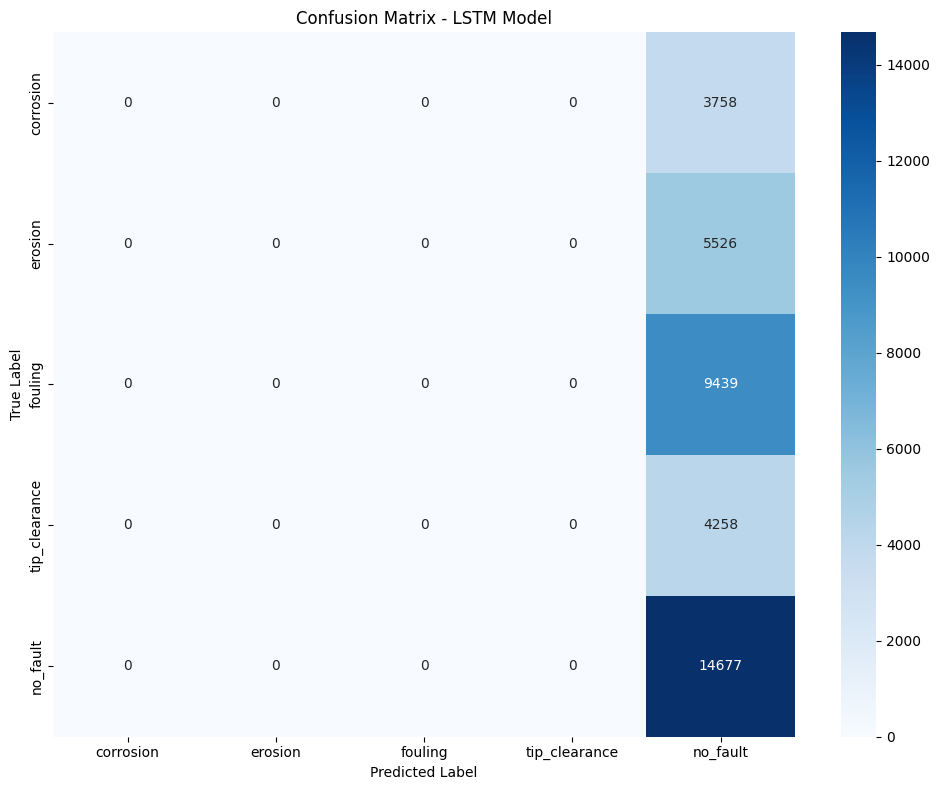

In [17]:
# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix - LSTM Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('../results/confusion_matrix_lstm.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Training History Visualization

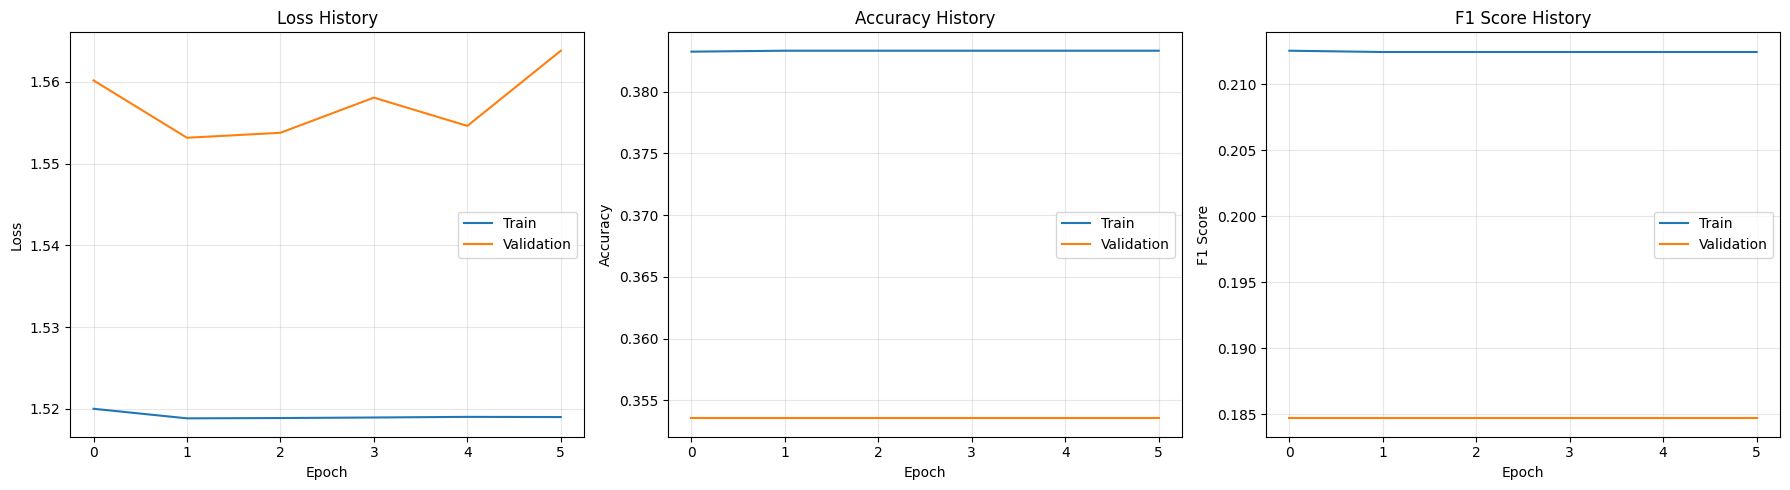

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss History')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train')
axes[1].plot(history['val_acc'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy History')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# F1 Score
axes[2].plot(history['train_f1'], label='Train')
axes[2].plot(history['val_f1'], label='Validation')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score History')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/training_history_lstm.png', dpi=300, bbox_inches='tight')
plt.show()